# Let's play Black Jack!

Written on a lazy Saturday. The functions got so numerous I moved them to an external file.

In [1]:
import blackjack as bj
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

While this notebook was originally created to see if I could understand counting cards, it has grown into something else. What that is I'm not sure, but I'm playing with probabilities and Black Jack logic.

### Establishing the game

Black Jack is a card game between at least two people. The objective of the game is to achieve a hand of cards valuing as close to 21 as possible. Two cards are initially dealt face down to each player. The players then take turns requesting more cards and adding to their hand until they are confident they can beat the dealer.

It is possible to keep track of the cards that have been played, and estimate the probability of drawing certain cards. This is called card counting, and what I initially wanted to try to program. Now I am tinkering with the game in general.



First we need to decide how many decks of cards we want to play with. These determine the shoe size, a tuneable parameter of the simulation. 

In [2]:
shoe_size = 8

Next we can determine how many games we want to play. A game consists of multiple hands between a player and a dealer. Both player and dealer have a target, and will hit until they meet or exceed the target. Hands are dealt until the shoe is exhausted. Score is kept by how many hands are won by both player and dealer.

In [3]:
n_games = 1000

Next, we can tune the betting targets. These are the score thresholds that will make the player stop hitting

In [4]:
dealer_target = 17
player_target = 17

Now we are ready to start our simulation!

In [5]:
# initialize a list to keep track of game scores
scoreboard = []

for i in tqdm(range(n_games)):
    wins = {
        'Player':0,
        'Dealer':0
    }
    # create shoe and shuffle
    shoe = bj.create_shoe(n_decks = shoe_size)
    
    # need at least 4 cards to start a hand, so if we end up with fewer, call it a day
    while len(shoe) > 4:
        
        winner, shoe = bj.play_hand(shoe, player_target, dealer_target)
    
        wins[winner] += 1

    scoreboard.append(wins)

scoreboard = pd.DataFrame(scoreboard)
scoreboard.head()

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1831.70it/s]


,Player,Dealer
0,32,45
1,28,49
2,27,51
3,28,51
4,29,49


Now plot histograms of the scores

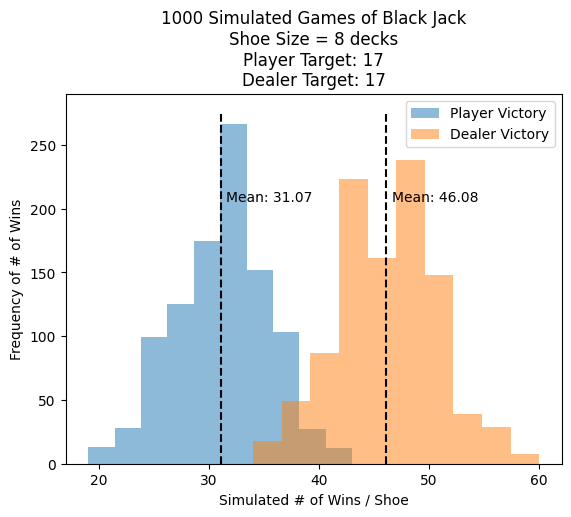

In [6]:
# Now let's plot some stuff
mean_player_wins = scoreboard['Player'].mean()
mean_dealer_wins = scoreboard['Dealer'].mean()


# get frequency of wins to establish y max.
# this will be used to draw the mean line.
player_counts, _ = np.histogram(scoreboard['Player'], bins=10)
dealer_counts, _ = np.histogram(scoreboard['Dealer'], bins=10)
ymax = max(player_counts.max(), dealer_counts.max()) + 10 


# establish figure and draw histograms
plt.figure()
plt.hist(scoreboard['Player'], alpha = 0.5, label = 'Player Victory')
plt.hist(scoreboard['Dealer'], alpha = 0.5, label = 'Dealer Victory')

# draw the mean as a dotted line
plt.plot((mean_dealer_wins, mean_dealer_wins), (0, ymax), '--', c = 'k')
plt.plot((mean_player_wins, mean_player_wins), (0, ymax), '--', c = 'k')

# write th emean 
plt.text(mean_player_wins + 0.5, ymax - 70, f'Mean: {mean_player_wins:.2f}', color='k')
plt.text(mean_dealer_wins + 0.5, ymax - 70, f'Mean: {mean_dealer_wins:.2f}', color='k')

# titles and labels and stuff
plt.ylabel('Frequency of # of Wins')
plt.xlabel('Simulated # of Wins / Shoe')
plt.title(
    f'{n_games} Simulated Games of Black Jack\n'
    f'Shoe Size = {shoe_size} decks\n'
    # f'No Card Counting\n'
    f'Player Target: {player_target}\nDealer Target: {dealer_target}'
)
plt.legend()
plt.show()

Okay, interesting start. Now, what is the ideal target?

Run a simulation for different "k" values to test different betting targets

In [7]:
# keep track of results of games
results = []

# iterate a range of k player targets
for k in tqdm(range(4, 19, 1)):
    player_target = k
    
    # simulate the games and transform the results to a dataframe
    scoreboard = pd.DataFrame(
        bj.simulate_games(
            n_games,
            shoe_size,
            player_target,
            dealer_target
        )
    ) 
    
    player_mean = scoreboard['Player'].mean()
    dealer_mean = scoreboard['Dealer'].mean() 
    
    player_std = scoreboard['Player'].std()
    dealer_std = scoreboard['Dealer'].std()
    
    results.append({
        'Player Target':player_target,
        'Player Mean Wins':player_mean,
        'Player Wins STD':player_std,
        'Dealer Mean Wins':dealer_mean,
        'Dealer Wins STD':dealer_std
    })
    
summary_df = pd.DataFrame(results)
summary_df

100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.44it/s]


,Player Target,Player Mean Wins,Player Wins STD,Dealer Mean Wins,Dealer Wins STD
0,4,35.795,4.082112,50.194,4.691095
1,5,35.480,4.158954,50.455,4.802399
2,6,35.510,4.327890,50.330,4.925379
3,7,35.378,4.335425,50.044,4.938264
4,8,35.397,4.240209,49.583,4.858468
5,9,35.182,4.443267,49.237,5.047604
6,10,35.385,4.268840,48.352,4.873587
7,11,35.733,4.192528,47.185,4.787243
8,12,36.541,4.282132,45.448,4.847969
9,13,35.756,4.077142,45.110,4.603378


Now plot the scores to visualize winning probabilities

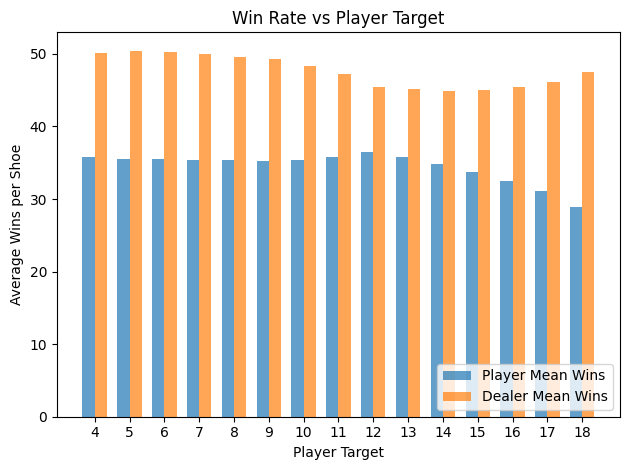

In [8]:
player_targets = summary_df['Player Target']
player_means = summary_df['Player Mean Wins']
dealer_means = summary_df['Dealer Mean Wins']

# Bar width and position offsets
bar_width = 0.35
x = np.arange(len(player_targets))  # the label locations

# Create bar plot
plt.bar(x - bar_width / 2, player_means, width = bar_width, label = 'Player Mean Wins', alpha=0.7)
plt.bar(x + bar_width / 2, dealer_means, width = bar_width, label = 'Dealer Mean Wins', alpha=0.7)

# Add labels, ticks, and title
plt.xticks(x, player_targets)
plt.xlabel('Player Target')
plt.ylabel('Average Wins per Shoe')
plt.title('Win Rate vs Player Target')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()


Now let's get some card counting.

It's simple at the core. Keep track of how many cards have been played with a running total. Cards rank 2-6 assign 1 point, rank 7-9 assign 0 points, and > rank 10 assign -1 point. When the running total is high, >=3, we adjust our betting target. Low cards have been dealt recently, so we should expect a higher card. Conversely, when the running total is low, we have seen more high cards than low cards, so we expect to see smaller value cards. We then adjust our betting target to be higher.

First we try without card counting

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1238.18it/s]


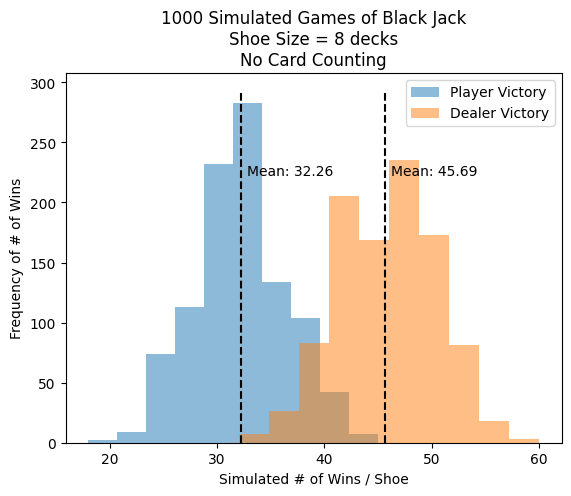

In [9]:
scoreboard = []

for i in tqdm(range(n_games)):
    wins = {
        'Player':0,
        'Dealer':0
    }
    shoe = bj.create_shoe(n_decks = shoe_size)
    
    while len(shoe) > 4:
        
        winner, shoe = bj.play_hand(shoe, player_target = 16, dealer_target = 17)
    
        wins[winner] += 1

    scoreboard.append(wins)

scoreboard = pd.DataFrame(scoreboard)
# print(f"Avg player wins: {}")
# print(f"Avg player wins: {scoreboard['Dealer'].mean()}")

mean_player_wins = scoreboard['Player'].mean()
mean_dealer_wins = scoreboard['Dealer'].mean()



player_counts, _ = np.histogram(scoreboard['Player'], bins=10)
dealer_counts, _ = np.histogram(scoreboard['Dealer'], bins=10)
ymax = max(player_counts.max(), dealer_counts.max()) + 10  # buffer of 10

plt.hist(scoreboard['Player'], alpha = 0.5, label = 'Player Victory')
plt.hist(scoreboard['Dealer'], alpha = 0.5, label = 'Dealer Victory')

plt.plot((mean_dealer_wins, mean_dealer_wins), (0, ymax), '--', c = 'k')
plt.plot((mean_player_wins, mean_player_wins), (0, ymax), '--', c = 'k')

plt.text(mean_player_wins + 0.5, ymax - 70, f'Mean: {mean_player_wins:.2f}', color='k')
plt.text(mean_dealer_wins + 0.5, ymax - 70, f'Mean: {mean_dealer_wins:.2f}', color='k')

plt.ylabel('Frequency of # of Wins')
plt.xlabel('Simulated # of Wins / Shoe')
plt.title(f'{n_games} Simulated Games of Black Jack\nShoe Size = {shoe_size} decks\nNo Card Counting')
plt.legend()
plt.show()

And now with card counting

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1018.70it/s]


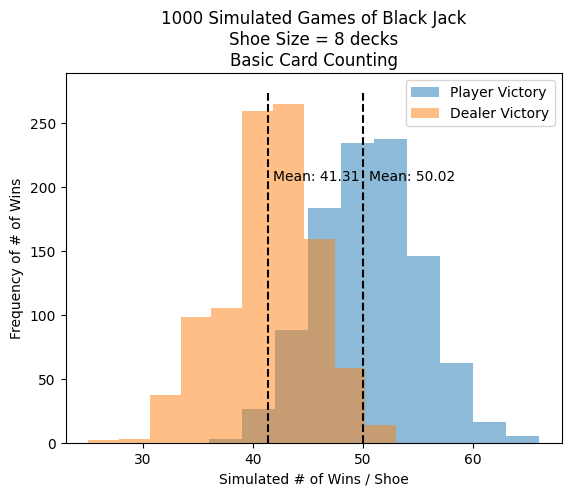

In [10]:
scoreboard = []

for i in tqdm(range(n_games)):
    wins = {
        'Player':0,
        'Dealer':0
    }
    shoe = bj.create_shoe(n_decks = shoe_size)

    running_count = 0
    
    while len(shoe) > 4:
        
        winner, shoe, running_count = bj.play_hand_with_player_counting(
            shoe, running_count, 8, dealer_target
        )
    
        wins[winner] += 1

    scoreboard.append(wins)

scoreboard = pd.DataFrame(scoreboard)

mean_player_wins = scoreboard['Player'].mean()
mean_dealer_wins = scoreboard['Dealer'].mean()


player_counts, _ = np.histogram(scoreboard['Player'], bins=10)
dealer_counts, _ = np.histogram(scoreboard['Dealer'], bins=10)
ymax = max(player_counts.max(), dealer_counts.max()) + 10  # buffer of 10

plt.hist(scoreboard['Player'], alpha = 0.5, label = 'Player Victory')
plt.hist(scoreboard['Dealer'], alpha = 0.5, label = 'Dealer Victory')

plt.plot((mean_dealer_wins, mean_dealer_wins), (0, ymax), '--', c = 'k')
plt.plot((mean_player_wins, mean_player_wins), (0, ymax), '--', c = 'k')

plt.text(mean_player_wins + 0.5, ymax - 70, f'Mean: {mean_player_wins:.2f}', color='k')
plt.text(mean_dealer_wins + 0.5, ymax - 70, f'Mean: {mean_dealer_wins:.2f}', color='k')

plt.ylabel('Frequency of # of Wins')
plt.xlabel('Simulated # of Wins / Shoe')
plt.title(f'{n_games} Simulated Games of Black Jack\nShoe Size = {shoe_size} decks\nBasic Card Counting')
plt.legend()
plt.show()

Run a similar simulation of multiple games to find target optimization.

In [11]:
# keep track of results of games
results = []

# iterate a range of k player targets
for k in tqdm(range(4, 19, 1)):
    player_target = k
    
    # simulate the games and transform the results to a dataframe
    scoreboard = pd.DataFrame(
        bj.simulate_games_with_counting(
            n_games,
            shoe_size,
            player_target,
            dealer_target
        )
    ) 
    
    player_mean = scoreboard['Player'].mean()
    dealer_mean = scoreboard['Dealer'].mean() 
    
    player_std = scoreboard['Player'].std()
    dealer_std = scoreboard['Dealer'].std()
    
    results.append({
        'Player Target':player_target,
        'Player Mean Wins':player_mean,
        'Player Wins STD':player_std,
        'Dealer Mean Wins':dealer_mean,
        'Dealer Wins STD':dealer_std
    })
    
summary_df = pd.DataFrame(results)
summary_df

100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.15it/s]


,Player Target,Player Mean Wins,Player Wins STD,Dealer Mean Wins,Dealer Wins STD
0,4,51.898,4.943484,40.571,4.481857
1,5,51.783,4.830035,40.573,4.417033
2,6,51.429,4.946456,40.681,4.524346
3,7,51.126,4.965358,40.699,4.551386
4,8,50.106,5.070945,41.192,4.707791
5,9,49.086,4.766269,41.709,4.437343
6,10,47.156,4.909763,42.972,4.605261
7,11,44.358,4.794040,44.899,4.511891
8,12,41.351,4.894257,46.974,4.668524
9,13,38.260,4.564344,48.410,4.527958


Plot the results

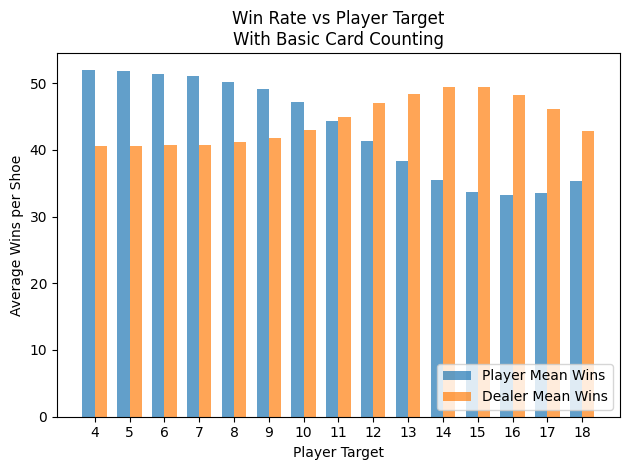

In [12]:
player_targets = summary_df['Player Target']
player_means = summary_df['Player Mean Wins']
dealer_means = summary_df['Dealer Mean Wins']

# Bar width and position offsets
bar_width = 0.35
x = np.arange(len(player_targets))  # the label locations

# Create bar plot
plt.bar(x - bar_width / 2, player_means, width = bar_width, label = 'Player Mean Wins', alpha=0.7)
plt.bar(x + bar_width / 2, dealer_means, width = bar_width, label = 'Dealer Mean Wins', alpha=0.7)

# Add labels, ticks, and title
plt.xticks(x, player_targets)
plt.xlabel('Player Target')
plt.ylabel('Average Wins per Shoe')
plt.title('Win Rate vs Player Target\nWith Basic Card Counting')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()
